In [1]:
# TrainBaseModelAugmentation.ipynb 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt



2025-07-31 00:49:17.948392: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-31 00:49:17.950335: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-31 00:49:17.962615: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-31 00:49:17.987393: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753940958.019256    3561 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753940958.02

In [2]:
#  Load Dataset
image_size = (180, 180)
batch_size = 16

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "food_6",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode="categorical",
)

Found 400 files belonging to 4 classes.
Using 320 files for training.
Using 80 files for validation.


2025-07-31 00:49:23.655400: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [4]:
# Define Data Augmentation 
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.1),
])


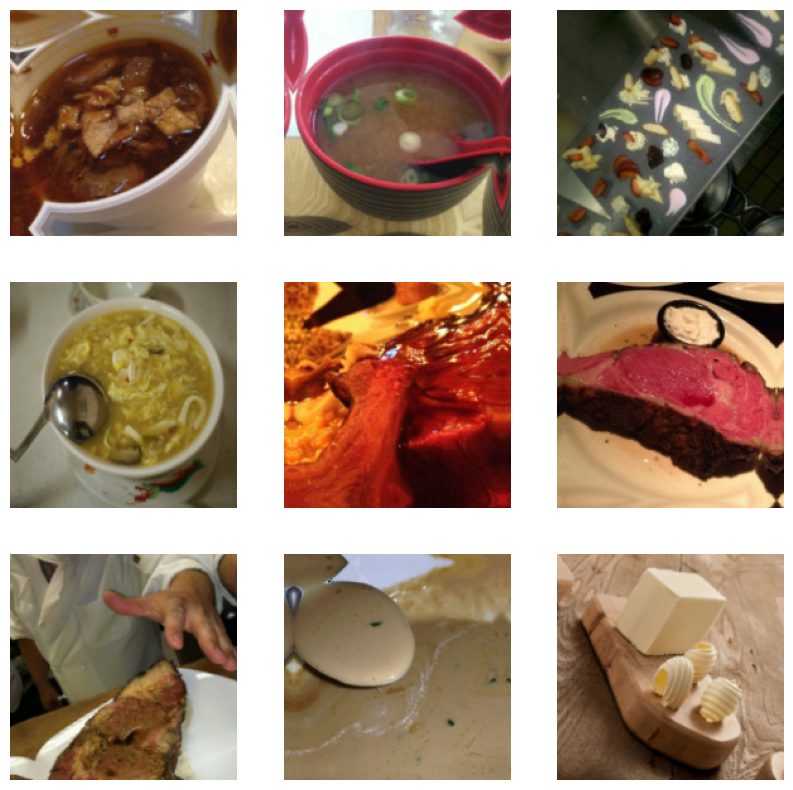

In [22]:
#  Visualize Data Augmentation 
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    augmented_images = data_augmentation(images)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[i].numpy().astype("uint8"))
        plt.axis("off")
plt.show()


In [24]:

# Setup Transfer Learning Model 
base_model = keras.applications.MobileNetV2(
    input_shape=image_size + (3,),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False

inputs = keras.Input(shape=image_size + (3,))
x = data_augmentation(inputs)
x = keras.applications.mobilenet_v2.preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(4, activation="softmax")(x)
model = keras.Model(inputs, outputs)

/tmp/ipykernel_3561/1487356856.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = keras.applications.MobileNetV2(


In [25]:

#  Compiling and Train Model 
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=["accuracy"]
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20
)

Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 403ms/step - accuracy: 0.3430 - loss: 1.5166 - val_accuracy: 0.7125 - val_loss: 0.8267
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 335ms/step - accuracy: 0.6764 - loss: 0.8002 - val_accuracy: 0.8125 - val_loss: 0.6333
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 345ms/step - accuracy: 0.7740 - loss: 0.5916 - val_accuracy: 0.7875 - val_loss: 0.6143
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 349ms/step - accuracy: 0.8718 - loss: 0.3822 - val_accuracy: 0.8375 - val_loss: 0.5455
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 293ms/step - accuracy: 0.8272 - loss: 0.4136 - val_accuracy: 0.8000 - val_loss: 0.5023
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 300ms/step - accuracy: 0.8849 - loss: 0.3174 - val_accuracy: 0.8375 - val_loss: 0.5016
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 298ms/step - accuracy: 0.8704 - loss: 0.3504 - val_accuracy: 0.8375 - val_loss: 0.4412
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 315ms/step - accuracy: 0.9194 - loss: 0.2655 - val_accuracy: 0

In [26]:
model.save("mobilenet_augmented.keras")



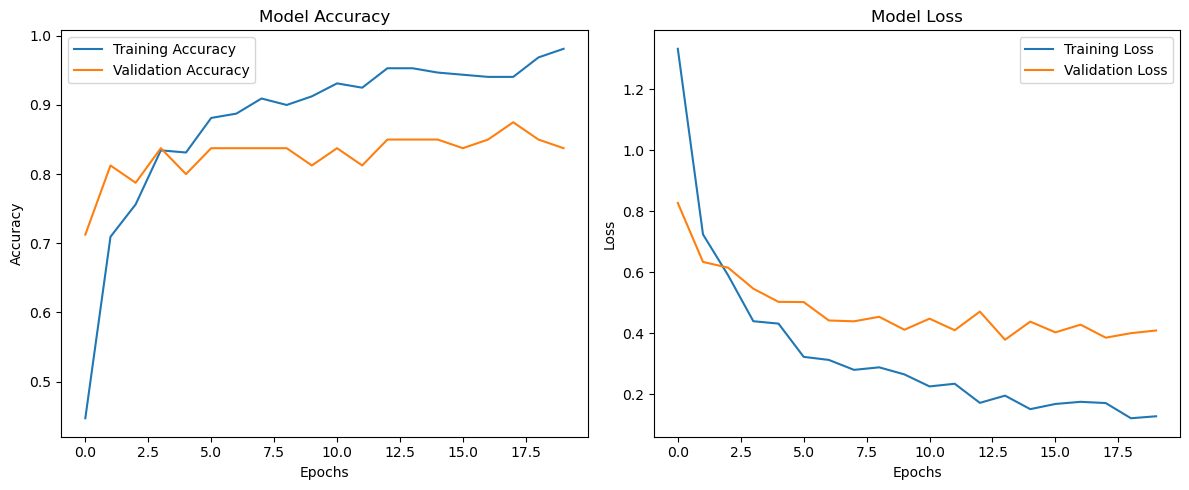

In [27]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot Accuracy
axs[0].plot(range(len(history.history["accuracy"])), history.history["accuracy"], label="Training Accuracy")
axs[0].plot(range(len(history.history["val_accuracy"])), history.history["val_accuracy"], label="Validation Accuracy")
axs[0].set_title("Model Accuracy")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Accuracy")
axs[0].legend()

# Plot Loss
axs[1].plot(range(len(history.history["loss"])), history.history["loss"], label="Training Loss")
axs[1].plot(range(len(history.history["val_loss"])), history.history["val_loss"], label="Validation Loss")
axs[1].set_title("Model Loss")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Loss")
axs[1].legend()

plt.tight_layout()
plt.show()
